# Emotion Classification in Sundanese Sentence

## The obligatory part

### Import the important library

In [1]:
import pandas as pd
import re

### Data path

In [2]:
data = pd.read_csv('../Dataset/data.csv')
stopwords_path = '../Dataset/stopwordv2.txt'
with open(stopwords_path, 'r') as file:
    custom_stopwords = set([line.strip() for line in file.readlines()])

### Lowercase

In [3]:
data['lowercase'] = data['data'].str.lower()

### Create dictionary

In [4]:
dictionary = pd.read_csv('../Dataset/result_v2.csv', delimiter=';')

In [5]:
dictionary['kata_dasar'] = dictionary['kata_dasar'].fillna(dictionary['repeated_char'])

#### Mapping dict

In [6]:
dictionary_map = dictionary.set_index('repeated_char')['kata_dasar'].to_dict()

In [7]:
data['mapping_dict'] = data['lowercase'].replace(dictionary_map, regex=True)

### Remove numbering (non alphabet)

In [8]:
data['remove_non_alphabet'] = data['mapping_dict'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

### Remove whitespaces

In [9]:
data['no_whitespace'] = data['remove_non_alphabet'].apply(lambda x: re.sub(r'\s+', ' ', x))

### Remove punctuation

In [10]:
data['no_punctuation'] = data['no_whitespace'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

### Apply standardized words

#### Cosine similarity to correct the words

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [12]:
standardized_word = pd.read_csv('../Dataset/standardized_word.csv')

In [13]:
standardized_list = standardized_word['standard'].tolist()

In [14]:
vectorizer = TfidfVectorizer()
standardized_vector = vectorizer.fit_transform(standardized_list)

In [15]:
def optimized_standardize_words(text, standardized_list, standardized_vectors):
    words = text.split()
    standardized_text = []
    
    for word in words:
        word_vector = vectorizer.transform([word])
        
        similarities = cosine_similarity(word_vector, standardized_vectors).flatten()
        
        max_similarity = max(similarities)
        if max_similarity > 0.7:
            best_match = standardized_list[np.argmax(similarities)]
        else:
            best_match = word
        
        standardized_text.append(best_match)
    
    return " ".join(standardized_text)

In [16]:
data['standardized_word'] = data['no_punctuation'].apply(
    lambda x: optimized_standardize_words(x, standardized_list, standardized_vector)
)

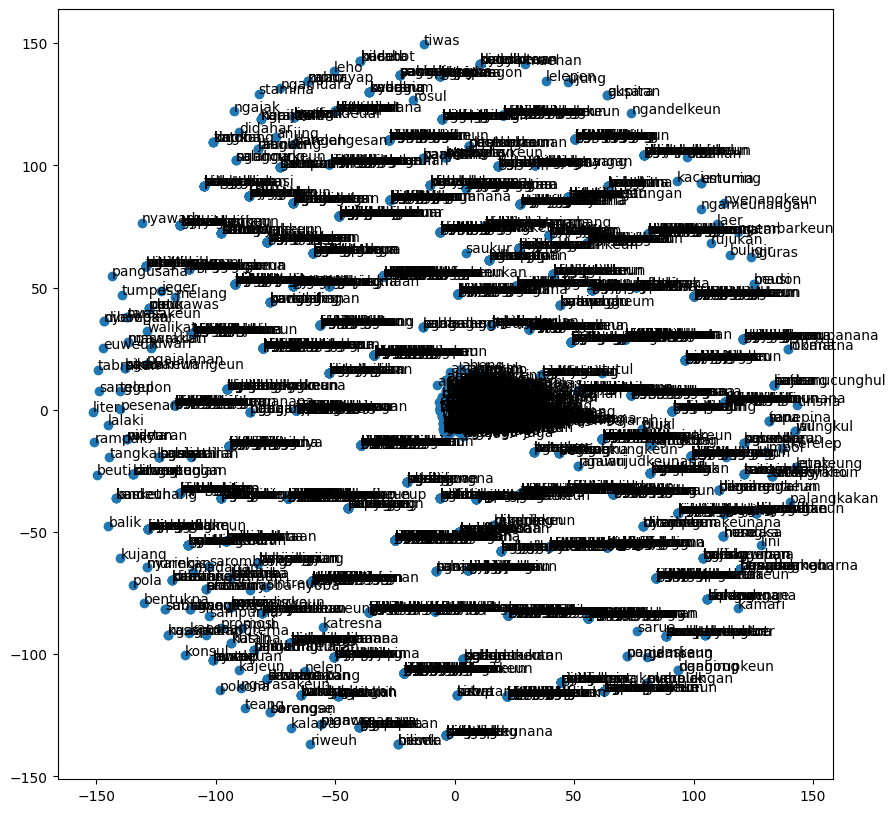

In [17]:
# visualization plot the result of cosine similarity with words similar
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
word_vectors_tsne = tsne.fit_transform(standardized_vector.toarray())

plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1])

for i, word in enumerate(standardized_list):
    plt.annotate(word, (word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]))
    
plt.show()


### Stopwords

In [18]:
data['stopwords'] = data['standardized_word'].apply(lambda x: ' '.join([word for word in x.split() if word not in custom_stopwords]))

### Tokenizing

In [19]:
data['tokenized'] = data['stopwords'].apply(lambda x: x.split())

In [20]:
data

,label,data,lowercase,mapping_dict,remove_non_alphabet,no_whitespace,no_punctuation,standardized_word,stopwords,tokenized
0,anger,"sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...","sok geura leungit atuh sia teh corona, matak g...",sok geura leungit atuh sia teh corona matak g...,sok geura leungit atuh sia teh corona matak ge...,sok geura leungit atuh sia teh corona matak ge...,sok geura-giru leungit atuh sia teh corona mat...,geura-giru leungit corona gelo yeuh uhenteul p...,"[geura-giru, leungit, corona, gelo, yeuh, uhen..."
1,anger,"Nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna","nu katoel katuhu nu nyerina kenca, goblog wasitna",nu katoel katuhu nu nyerina kenca goblog wasitna,nu katoel katuhu nu nyerina kenca goblog wasitna,nu katoel katuhu nu nyerina kenca goblog wasitna,nu boga katoel katuhu nu boga nyerina kenca go...,boga katoel katuhu boga nyerina kenca wasitna,"[boga, katoel, katuhu, boga, nyerina, kenca, w..."
2,joy,Bingah pisan patepang sareng pangerasa. Sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa. sing k...,bingah pisan patepang sareng pangerasa sing k...,bingah pisan patepang sareng pangerasa sing ka...,bingah pisan patepang sareng pangerasa sing ka...,bingah pisan patepang sareng pangerasa sing sa...,bingah patepang pangerasa sing katampi kalayan...,"[bingah, patepang, pangerasa, sing, katampi, k..."
3,fear,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu.. lalakon hirup teh asa nyor...,asa hariwang kieu lalakon hirup teh asa nyor...,asa hariwang kieu lalakon hirup teh asa nyoran...,asa hariwang kieu lalakon hirup teh asa nyoran...,asa hariwang kieu lalakon hirup teh asa nyoran...,hariwang lalakon hirup nyorangan,"[hariwang, lalakon, hirup, nyorangan]"
4,anger,"Orang mana sih anying, sampis pisan. Bunuh ae ...","orang mana sih anying, sampis pisan. bunuh ae ...","orang mana sih anjing, sampis pisan. bunuh ae ...",orang mana sih anjing sampis pisan bunuh ae ...,orang mana sih anjing sampis pisan bunuh ae la...,orang mana sih anjing sampis pisan bunuh ae la...,orang mana sih anjing sampis pisan bunuh ae la...,sampis bunuh ae bunuh,"[sampis, bunuh, ae, bunuh]"
...,...,...,...,...,...,...,...,...,...,...
2093,joy,Meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak eeeuy uiiiiing....!,meuni ngeunah ngabarakatak euy uing....!,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak euy uing,meuni ngeunah ngabarakatak,"[meuni, ngeunah, ngabarakatak]"
2094,joy,"Meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...","meuni ku endah, tebeda nami na gusti nu agung,...",meuni ku endah tebeda nami na gusti nu agung ...,meuni ku endah tebeda nami na gusti nu agung d...,meuni ku endah tebeda nami na gusti nu agung d...,meuni ku endah tebeda nami na gusti nu boga ag...,meuni endah tebeda nami boga agung dimana bumi...,"[meuni, endah, tebeda, nami, boga, agung, dima..."
2095,joy,"meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...","meuni bungah kieu euy meunang di ngalam, nuhun...",meuni bungah kieu euy meunang di ngalam nuhun...,meuni bungah kieu euy meunang di ngalam nuhun ...,meuni bungah kieu euy meunang di ngalam nuhun ...,meuni bungah kieu euy meunang di ngalam hatur ...,meuni bungah meunang ngalam hatur nuhun hatur ...,"[meuni, bungah, meunang, ngalam, hatur, nuhun,..."
2096,joy,"Meuni bingah ningalna ya alloh mudah"" PaS 02 k...","meuni bingah ningalna ya alloh mudah"" pas 02 k...","meuni bingah ningalna ya kabehah mudah"" pas 02...",meuni bingah ningalna ya kabehah mudah pas ...,meuni bingah ningalna ya kabehah mudah pas ken...,meuni bingah ningalna ya kabehah mudah pas ken...,meuni bingah ning

In [21]:
data.to_csv('../Dataset/complete_clean_data.csv', index=False)

## Model LSTM

### Import the important library

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GaussianNoise
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight


/Users/mac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Define variable

In [23]:
texts = data['tokenized'].tolist()
labels = data['label'].tolist()

In [24]:
len(texts), len(labels)

(2098, 2098)

In [25]:
all_words = [word for tokens in texts for word in tokens]
unique_words = list(set(all_words))
word_index = {word: i + 1 for i, word in enumerate(unique_words)}

In [26]:
sequences = [[word_index[word] for word in tokens if word in word_index] for tokens in texts]

In [27]:
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [28]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

#### Weighted classes

In [30]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [31]:
class_weight_dict

{0: np.float64(1.0256723716381417),
 1: np.float64(1.0409429280397022),
 2: np.float64(0.9710648148148148),
 3: np.float64(0.966589861751152)}

In [32]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [115]:
len(word_index)

6262

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2515 - loss: 8.6932 - val_accuracy: 0.2143 - val_loss: 8.0944 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2741 - loss: 7.9206 - val_accuracy: 0.2917 - val_loss: 7.3920 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.2445 - loss: 7.2478 - val_accuracy: 0.2917 - val_loss: 6.7649 - learning_rate: 1.0000e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.2358 - loss: 6.6303 - val_accuracy: 0.2917 - val_loss: 6.2053 - learning_rate: 1.0000e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.2463 - loss: 6.0872 - val_accuracy: 0.2917 - val_loss: 5.7058 - learning_rate: 1.0000e-04
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.2316 - loss: 5.5986 - val_accuracy: 0.2083 - val_loss: 5.2603 - learning_rate: 1.0000e-04
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.2582 

### Result

#### Accuracy test

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test: {accuracy:.2%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7007 - loss: 1.9587
Test: 70.00%


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       109
           1       0.59      0.66      0.62       108
           2       0.81      0.79      0.80       107
           3       0.57      0.69      0.63        96

    accuracy                           0.70       420
   macro avg       0.72      0.70      0.70       420
weighted avg       0.72      0.70      0.71       420



<Axes: >

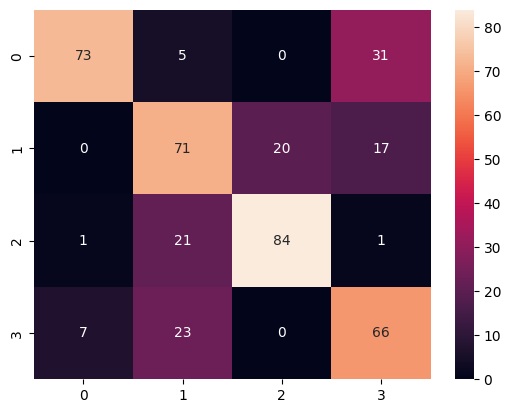

In [39]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d')

#### Visualization accuracy

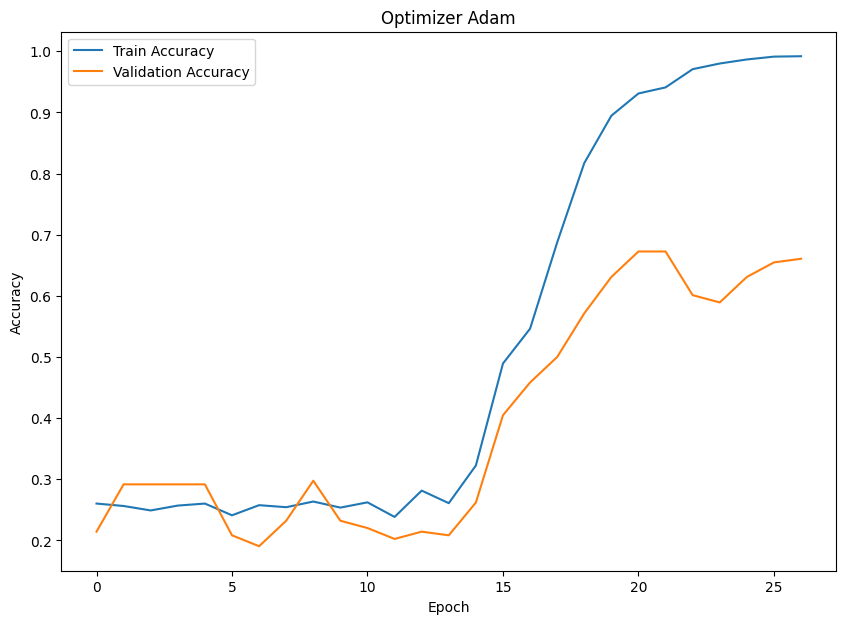

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Optimizer Adam')
plt.show()

#### Visualization loss

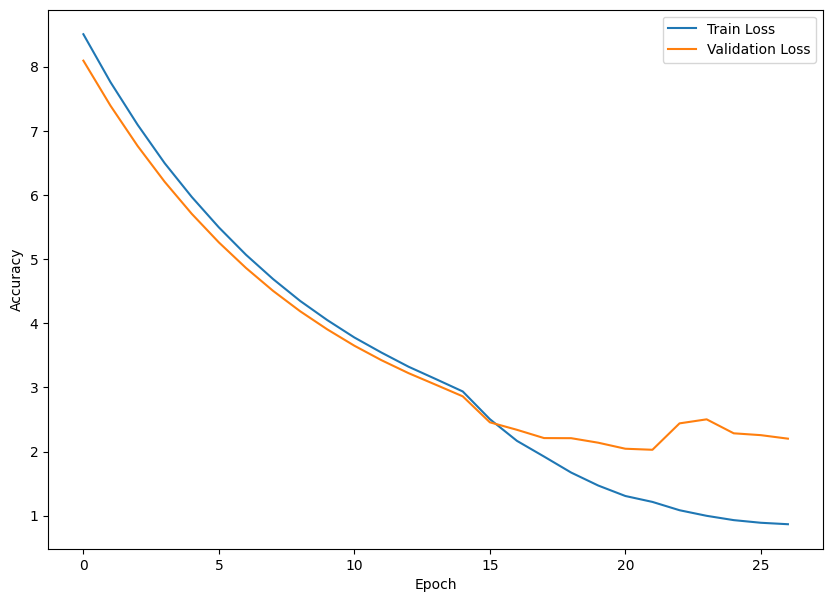

In [41]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# export model
model.save('../Model/model.h5')

In [43]:
# evaluate model using ROC AUC
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovr')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


np.float64(0.9041057246985192)

#### Predict emotion

In [44]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [45]:
model = load_model('../Model/model.h5')

In [46]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('\'', '')
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = optimized_standardize_words(text, standardized_list, standardized_vector)
    text = ' '.join([word for word in text.split() if word not in custom_stopwords])
    text = text.split()
    return text

In [47]:
texts = [
    'babaturanana datang ka bumi'
]

In [48]:
processed_texts = [preprocess_text(text) for text in texts]

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_texts)

In [50]:
sequences = tokenizer.texts_to_sequences(processed_texts)

In [51]:
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)

In [52]:
predictions = model.predict(padded_sequences)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


In [53]:
print("Predictions:")
print(predictions)

# Convert probabilities to predicted class (assuming you have 4 classes: happy, sad, angry, neutral)
predicted_classes = np.argmax(predictions, axis=-1)

# Map the predicted classes back to emotions (labels)
class_labels = ['happy', 'sad', 'angry', 'neutral']  # Adjust based on your model's classes
predicted_emotions = [class_labels[i] for i in predicted_classes]

print("Predicted emotions:")
print(predicted_emotions)

Predictions:
[[9.9010265e-01 5.5948080e-04 1.4237870e-03 7.9140784e-03]]
Predicted emotions:
['happy']


### Optimizer SGD Approach

In [54]:
# use optimizer sgd for lstm model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict)

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test: {accuracy:.2%}")

Epoch 1/50


/Users/mac/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.2409 - loss: 8.8700 - val_accuracy: 0.1964 - val_loss: 8.7539 - learning_rate: 0.0100
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.2430 - loss: 8.7290 - val_accuracy: 0.1964 - val_loss: 8.6161 - learning_rate: 0.0100
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.2494 - loss: 8.5827 - val_accuracy: 0.1964 - val_loss: 8.4794 - learning_rate: 0.0100
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.2431 - loss: 8.4500 - val_accuracy: 0.2024 - val_loss: 8.3427 - learning_rate: 0.0100
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.2601 - loss: 8.3207 - val_accuracy: 0.2917 - val_loss: 8.2081 - learning_rate: 0.0100
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.2727 - loss: 8.1767 - val_accuracy: 0.2917 - val_loss: 8.0779 - learning_rate: 0.0100
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.2660 - loss: 8.0531 - val_accuracy: 0.19

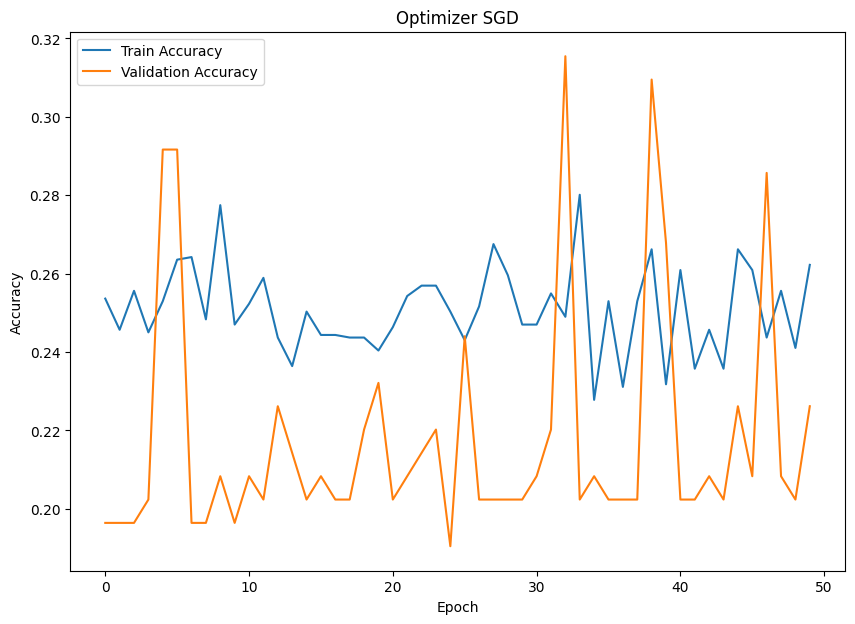

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Optimizer SGD')
plt.show()

### Optimizer RMSprop Approach

In [56]:
# use optimizer rmsprop for lstm model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(len(set(encoded_labels)), activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, clipnorm=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr], class_weight=class_weight_dict)

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test: {accuracy:.2%}")

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.2187 - loss: 6.8096 - val_accuracy: 0.2024 - val_loss: 3.5346 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2572 - loss: 3.0784 - val_accuracy: 0.2917 - val_loss: 2.1452 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.2507 - loss: 2.0219 - val_accuracy: 0.1964 - val_loss: 1.7254 - learning_rate: 0.0010
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.2471 - loss: 1.6677 - val_accuracy: 0.2143 - val_loss: 1.5218 - learning_rate: 0.0010
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.2577 - loss: 1.4914 - val_accuracy: 0.2143 - val_loss: 1.4291 - learning_rate: 0.0010
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.2435 - loss: 1.4178 - val_accuracy: 0.1964 - val_loss: 1.3970 - learning_rate: 0.0010
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.2487 - loss: 1.3941 - val_acc

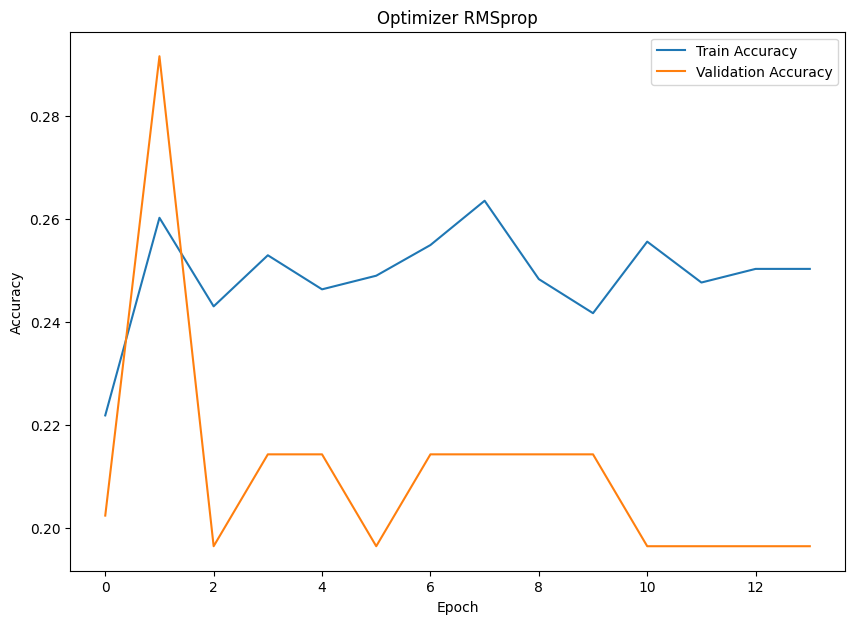

In [57]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Optimizer RMSprop')
plt.show()

## Model BERT

### Import the important library

In [58]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

/Users/mac/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Check the device cpu

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [60]:
text_column = 'stopwords'
label_column = 'label'

In [61]:
label_mapping = {label: idx for idx, label in enumerate(data[label_column].unique())}
data['label_encoded'] = data[label_column].map(label_mapping)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    data[text_column].values,
    data['label_encoded'].values,
    test_size=0.2,
    random_state=42
)

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [64]:
def encode_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

In [65]:
X_train_encoded = encode_texts(X_train, tokenizer)
X_test_encoded = encode_texts(X_test, tokenizer)

In [66]:
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

In [67]:
train_dataset = TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], y_train_tensor)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)

In [68]:
test_dataset = TensorDataset(X_test_encoded['input_ids'], X_test_encoded['attention_mask'], y_test_tensor)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=16)

In [69]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3

/Users/mac/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [71]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [72]:
import requests
import json

def send_webhook_message(message):
    url = 'https://discord.com/api/webhooks/1314074661881118821/Qrrbj25d-IIxCu3qhjJOYM3zsJwmT36ZLuXnwteaUq2pZjYGEQ44Po51a3GJEoyAWdFZ'
    data = {'text': message}
    requests.post(url, data=json.dumps(data), headers={'Content-Type': 'application/json'})
    
send_webhook_message('Training process has started')

In [ ]:
def train_model(model, dataloader, optimizer, scheduler, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        print(f'Epoch {epoch + 1}/{epochs}')
        for step, batch in enumerate(dataloader):
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        print(f'Average training loss: {avg_loss:.4f}')
        send_webhook_message(f'Epoch {epoch + 1}/{epochs}\nAverage training loss: {avg_loss:.4f}')
train_model(model, train_dataloader, optimizer, scheduler, epochs=3)

Epoch 1/3
Average training loss: 1.2797
Epoch 2/3
Average training loss: 0.8607
Epoch 3/3
Average training loss: 0.5459


In [74]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())
    return true_labels, predictions

In [75]:
true_labels, predictions = evaluate_model(model, test_dataloader)

### Result

In [76]:
print(classification_report(true_labels, predictions))
print(f'Accuracy: {accuracy_score(true_labels, predictions):.2%}')

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       109
           1       0.92      0.89      0.90       107
           2       0.86      0.81      0.83       108
           3       0.67      0.83      0.74        96

    accuracy                           0.80       420
   macro avg       0.80      0.80      0.80       420
weighted avg       0.81      0.80      0.80       420

Accuracy: 79.76%


In [ ]:
# visualization the clasification report result
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d')


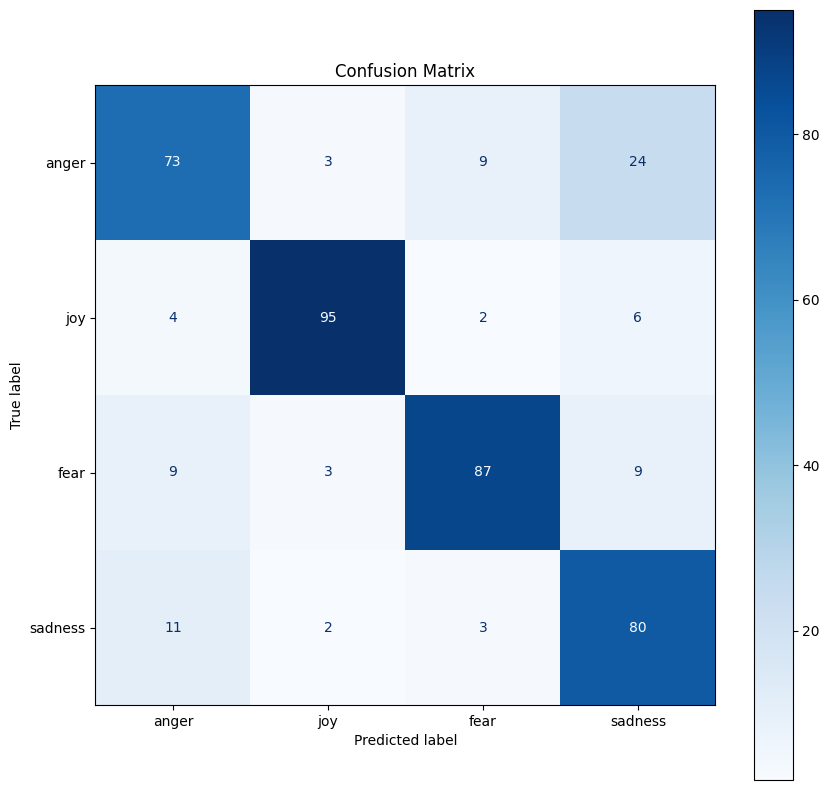

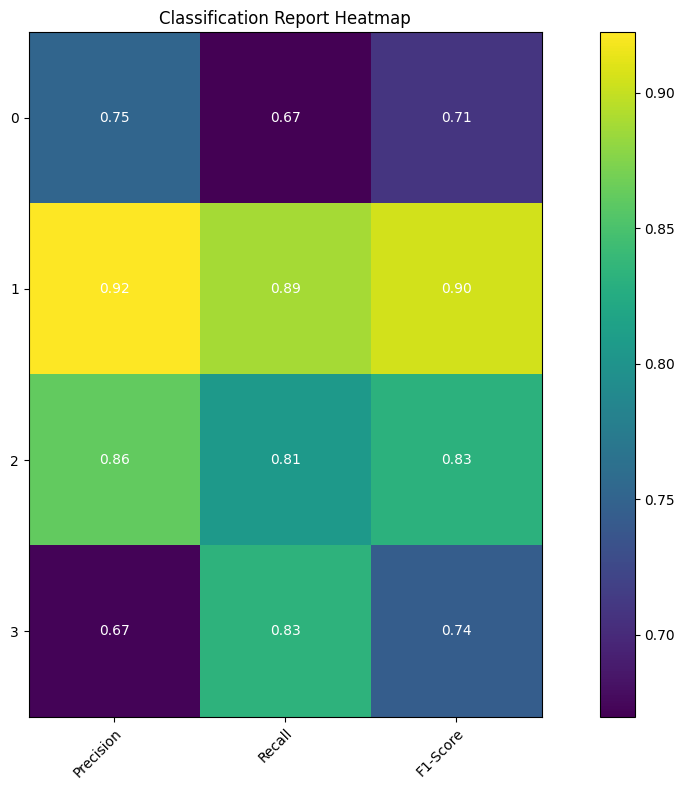

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_labels, predictions, output_dict=True)
categories = list(report.keys())[:-3]

report_values = np.array([[report[cat]['precision'], report[cat]['recall'], report[cat]['f1-score']] for cat in categories])
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(report_values, cmap='viridis')

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
ax.set_yticklabels(categories)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(categories)):
    for j in range(3):
        text = ax.text(j, i, f"{report_values[i, j]:.2f}", ha="center", va="center", color="white")

ax.set_title("Classification Report Heatmap")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


#### Export model BERT

In [78]:
torch.save(model, '../Model/bert_emotion_model.pth')

### Predict emotion use BERT

#### Import the important library

In [79]:
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [81]:
data_test = pd.read_csv('../Dataset/test.csv')

In [82]:
data_test.loc[31]

label                                                anger
data     maneh teh pakboi ulah ngaku2 belum pacaran atu...
Name: 31, dtype: object

In [83]:
# create def to apply lowercase, mapping dict, remove non alphabet, remove whitespace, remove punctuation, standardized word, stopwords, and tokenized
def preprocess_text(text):
    text = text.lower()
    text = text.replace('\'', '')
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = optimized_standardize_words(text, standardized_list, standardized_vector)
    text = ' '.join([word for word in text.split() if word not in custom_stopwords])
    text = text.split()
    return text


In [84]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))
model = torch.load('bert_emotion_model.pth')
model = model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/6x/lmc1htc9365gh92j_29fzc4m0000gn/T/ipykernel_22504/2674254823.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [103]:
story = """
'babaturanana datang ka imah'
"""

In [104]:
# split sentences
sentences = story.split('.')
sentences = [sentence for sentence in sentences if sentence]
normalized_sentences = [preprocess_text(sentence) for sentence in sentences]

In [105]:
sentences

["\n'babaturanana datang ka imah'\n"]

In [106]:
output = [' '.join(sublist) for sublist in normalized_sentences]

In [107]:
output

['babaturanana datang imah']

In [108]:
def encode_new_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

In [109]:
encode_sentences = encode_new_texts(output, tokenizer)
input_ids = encode_sentences['input_ids'].to(device)
attention_mask = encode_sentences['attention_mask'].to(device)

In [110]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = softmax(logits, dim=1).cpu().numpy()

label_mapping_reversed = {v: k for k, v in label_mapping.items()}

In [111]:
for i, sentences in enumerate(output):
    print(f"Kalimat : \"{sentences}\"")
    print(f"Emosi yang diprediksi : ")
    for label_idx, prob in enumerate(probabilities[i]):
        label = label_mapping_reversed[label_idx]
        print(f"{label} : {prob:.2%}")
    print()

Kalimat : "babaturanana datang imah"
Emosi yang diprediksi : 
anger : 6.65%
joy : 58.94%
fear : 1.11%
sadness : 33.31%



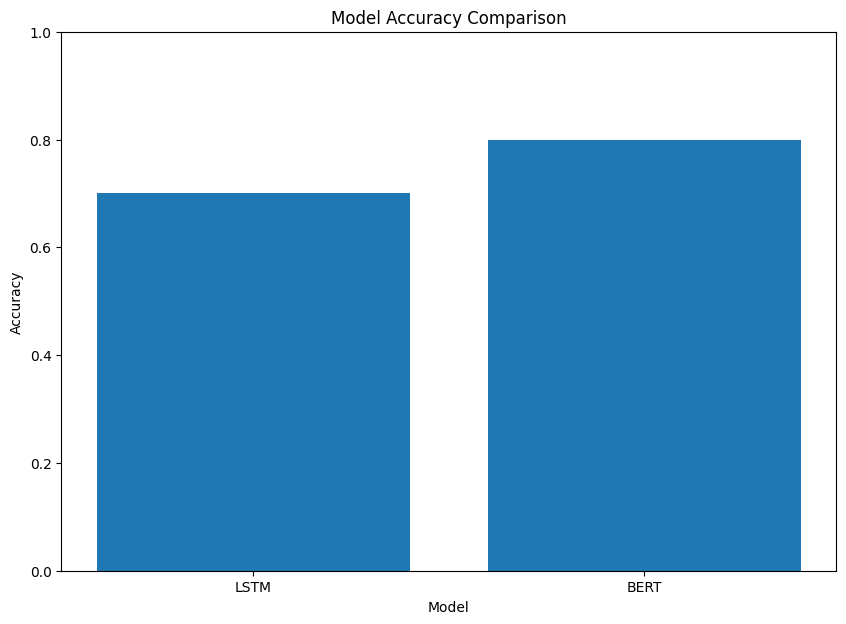

In [118]:
# visualization the result accuracy of the two model lstm and bert to show the comparison of accuracy
import matplotlib.pyplot as plt

lstm_accuracy = 0.70
bert_accuracy = 0.80

plt.figure(figsize=(10, 7))
plt.bar(['LSTM', 'BERT'], [lstm_accuracy, bert_accuracy])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

